# MONOCAMCCDRed a package to do CCD reduction for MONOCAM/LSST
===============================================================================================================

This is the notebook to do the whole CCD reduction pipeline using the **CCDPROC** python package from astropy astronomical tools.
We are considering raw data images that comes from fits file which header does not full conform to standard.
Some keywords are missing.

This notebook target bias and darks calculations.


Study Monocam 2016-05-11

- Creation date : Friday 2016 June 3rd
- Update : Monday 2016 June 20th
- Author Sylvie Dagoret-Campagne (SDC adapted for LSST from Matt Craig's example notebook)
- affiliation : LAL/IN2P3/CNRS

This notebook is inspired and adapted from the Matt Craig notebook available here
http://nbviewer.jupyter.org/gist/mwcraig/06060d789cc298bbb08e

## 1.) Required softwares

Please make sure you have this software installed before you begin (in addition to the usual scipy, numpy):

+ [astropy](http://astropy.org) v 0.4 or higher (install with: ``pip install astropy`` in a terminal/command window)
+ [ccdproc](http://ccdproc.readthedocs.org) v 0.1.1 or higher (install with: ``pip install ccdproc`` in a terminal/command window)
+ [msumastro](http://msumastro.readthedocs.org) v 0.5 or higher (install with : ``pip install msumastro`` in a terminal/command window)

## 2.) Main Packages imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits

import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [2]:
from scipy import stats  
import os
from datetime import datetime, timedelta

In [3]:
import libMonocamBaseImages as monoc

In [4]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.0.0


In [5]:
from msumastro import ImageFileCollection, TableTree
# I know you can't do correlated errors....
nddata.conf.warn_unsupported_correlated = False

In [6]:
now=datetime.utcnow()  # choose UTC time
datestr=str(now)
print 'standard date format for the analysis :',datestr
#  want the following format '2016-05-10T11:55:27.267'
date_of_analysis=now.strftime('%Y-%m-%dT%H:%M:%S')
print 'fits date format for the analysis : ',date_of_analysis

standard date format for the analysis : 2016-06-22 12:08:06.660672
fits date format for the analysis :  2016-06-22T12:08:06


## 3) Set some properties of the instrument that took these images

- MONOCAM, one of the 200 CCD plate of LSST camera.
- This CCD is 4Kx4K readout by 16 amplifiers

Eeach fits file contains a primary header plus the 16 images

- 16 images of size 544 x 2048 pixels
corresponding of :
- 8 columns of 544 pixels : 8 x 544 = 4352 pixels 
- 2 raws of 2048 pixels : 2 x 2048 = 4096 pixels

There is an excess of 4352-4096= 256 pixels along the columns.
It is possible there is 32 overscan slots.


A pre-look to the flats data using ds9 or python script allowed me to guess what are the Trim section and the Bias section

In [7]:
NB_OF_CHAN_AMPL=16    # 16 images in each of the fits file

# 4. Define a few convenience functions

All of these are really optional, but some are pretty convenient. They are provided in part to illustrate how one can combine the basic ``ccdproc`` commands into something more like a pipeline.

## a. Subtract overscan and trim images in a list

I have checked that substracting overscan region reduce very significantly the width of the pedestals (biases) distribution.
Obviously it is necessary to apply this pre-correction image by image.

(SDC)

In [8]:
def oscan_and_trim(image_list):
    """
    Remove overscan and trim a list of images. The original list is replaced by a list of images
    with the changes applied.
    """
    for idx, img in enumerate(image_list):
        oscan = ccdproc.subtract_overscan(img,overscan=img[:,521:544], add_keyword={'oscan_sub': True, 'calstat': 'O'}, model=models.Polynomial1D(1))
        image_list[idx] = ccdproc.trim_image(oscan[:,10:521], add_keyword={'trimmed': True, 'calstat': 'OT'})

## b. Calculate fast medians (only really needed until numpy 1.9)

###     A bottleneck-based replacement for ma.median for a *single* array

As explained above, in numpy 1.8.1 and lower the masked median of a stack of images is very slow.

In [9]:
def bn_median(masked_array, axis=None):
    """
    Perform fast median on masked array
    
    Parameters
    ----------
    
    masked_array : `numpy.ma.masked_array`
        Array of which to find the median.
    
    axis : int, optional
        Axis along which to perform the median. Default is to find the median of
        the flattened array.
    """
    data = masked_array.filled(fill_value=np.NaN)
    med = bn.nanmedian(data, axis=axis)
    # construct a masked array result, setting the mask from any NaN entries
    return np.ma.array(med, mask=np.isnan(med))

### A bottleneck-based replacement for a stack (i.e. list) of masked arrays

By "stack" I mean a group of images, e.g. darks of the same exposure, for which the appropriate baseline image for identifying bad pixels is a median image (rather than a median or mean of the whole stack)

In [10]:
def avg_over_images(masked_arr, axis=0):
    """
    Calculate average pixel value along specified axis
    """
    return np.ma.mean(masked_arr, axis=axis)

def med_over_images(masked_arr, axis=0):
    """
    Calculate median pixel value along specified axis
    
    Uses bottleneck.nanmedian for speed
    """
    
    dat = masked_arr.data.copy()
    dat[masked_arr.mask] = np.NaN
    return bn.nanmedian(dat, axis=axis)

### A little function for displaying image statistics....

..which is useful for determining scale when displaying an image.

In [11]:
imstats = lambda dat: (dat.min(), dat.max(), dat.mean(), dat.std())

### To make the list of biases

In [12]:
def BuildFilelist(path,name,ext='.fits',start=1,stop=99):
    '''
    Make the list of filenames required by ccdproc
    
    input:
       path : path of files
       name : common root of bias filenames
       ext  : extension of filenames
       start,stop : indexes of files
    output:
       full filename list
    '''
    filelist = []
    for num in range(start,stop+1,1):
        strnum=biasnumberstr= '{0:02d}'.format(num)  # python >= 2.6
        filename=name+strnum+ext
        fullfilename=os.path.join(path,filename)
        filelist.append(fullfilename)
    return filelist

## 5.) Read data

In [13]:
path='/Users/dagoret-campagnesylvie/iraf/MonoCamMay2016/20160511'
ext_filename='.fits'

## 6 ) The biases
=====================

In [14]:
root_biasfilename='bias_'
bias_startnum=1
bias_stopnum=53

In [15]:
rawbias_list=BuildFilelist(path,root_biasfilename,start=bias_startnum,stop=bias_stopnum)

In [16]:
NB_OF_BIAS=len(rawbias_list)

In [17]:
masterbias_out_filename='masterbias_ostrim_1.fits'

### a. First, load the data as a list of ``CCDData`` objects.

If you don't need to modify the metadata you could use ``ccdproc.CCDData.from_hdu(hdu)`` to create the ``CCDData`` object.

In [18]:
allrawbias = []
for chan in range(1,NB_OF_CHAN_AMPL+1,1):
    ccd_chan = [ ccdproc.CCDData.read(image_file, hdu=chan,unit="adu") for image_file in rawbias_list ]
    allrawbias.append(ccd_chan)

In [19]:
mbheader=allrawbias[0][0].header
mbheader['DATE-ANA']=date_of_analysis

### b. Subtract overscan and trim using convenience function

In [20]:
for chan in range(NB_OF_CHAN_AMPL):
    oscan_and_trim(allrawbias[chan])

### c. Combine biases using average

In [21]:
masterbias_list=[]
for chan in range(NB_OF_CHAN_AMPL):
    biases = ccdproc.Combiner(allrawbias[chan])
    #master_bias = biases.average_combine() # assymetric pedestals ==>  Not good at all, but perhaps we prefer this ?
    master_bias = biases.median_combine()  # median gives much more symetric gaussian distributed pedestals
    masterbias_list.append(master_bias)

### d. Make a pretty picture...

Because why wouldn't you?

In [22]:
print 'channel bias_min, bias_max, bias_mean, bias_std'
for chan in range(NB_OF_CHAN_AMPL):
    bias_min, bias_max, bias_mean, bias_std = imstats(np.asarray(masterbias_list[chan]))
    print '{:2d}      {:2.2f}      {:2.2f}      {:2.2f}      {:2.2f}'.format(chan+1,bias_min, bias_max, bias_mean, bias_std)
    
    #plt.figure(figsize=(5, 5))
    #plt.imshow(masterbias_list[chan], vmax=bias_mean + 4*bias_std, vmin=bias_mean - 4*bias_std)

channel bias_min, bias_max, bias_mean, bias_std
 1      -1.49      1.58      0.29      0.32
 2      -1.12      2.48      0.50      0.42
 3      -1.32      2.04      0.37      0.40
 4      -1.41      1.96      0.27      0.39
 5      -1.43      2.21      0.31      0.39
 6      -1.52      2.02      0.26      0.35
 7      -1.24      2.12      0.30      0.40
 8      -1.49      31.43      0.36      0.33
 9      -1.66      2.43      0.46      0.42
10      -1.52      2.34      0.44      0.40
11      -1.72      2.47      0.27      0.40
12      -1.34      2.51      0.57      0.43
13      -1.69      36.52      0.41      0.41
14      -1.52      36.76      0.27      0.39
15      -2.46      12.40      0.45      0.63
16      -1.13      42.01      1.17      0.80


In [23]:
def ShowMBImagesSet(masterbiaslist):
    '''
    Shows the whole set of CCD images
     - inputs argument:
       path : path of the fits file
       filename of the fits file
     - output the images of the whole CCD   
    '''
     
    NX=8 # number of images along the horizontal axis
    NY=2 # number of images along the vertical axis
    BIASMIN=-2.0
    BIASMAX=2.0
    f, axarr = plt.subplots(NY,NX,sharex='col', sharey='row',figsize=(15,15)) # figure organisation
    
    f.subplots_adjust(hspace=0.125,wspace=0.1)

    for index in range(NB_OF_CHAN_AMPL):  
        ix=index%8
        iy=index/8
        image_data = masterbiaslist[index].data
        im=axarr[iy,ix].imshow(image_data,vmin=BIASMIN,vmax=BIASMAX)  # plot the image
        if ix==0 and iy==0:
            im0=im
        plottitle='channel {}'.format(index+1)
        axarr[iy,ix].set_title(plottitle)
    
    title='Master Biases'
    cax = f.add_axes([0.95, 0.12, 0.03, 0.78]) # [left,bottom,width,height]    
    f.colorbar(im0, cax=cax)
   
    plt.suptitle(title,size=16)
    plt.savefig('masterbias_ostrim.pdf', bbox_inches='tight')

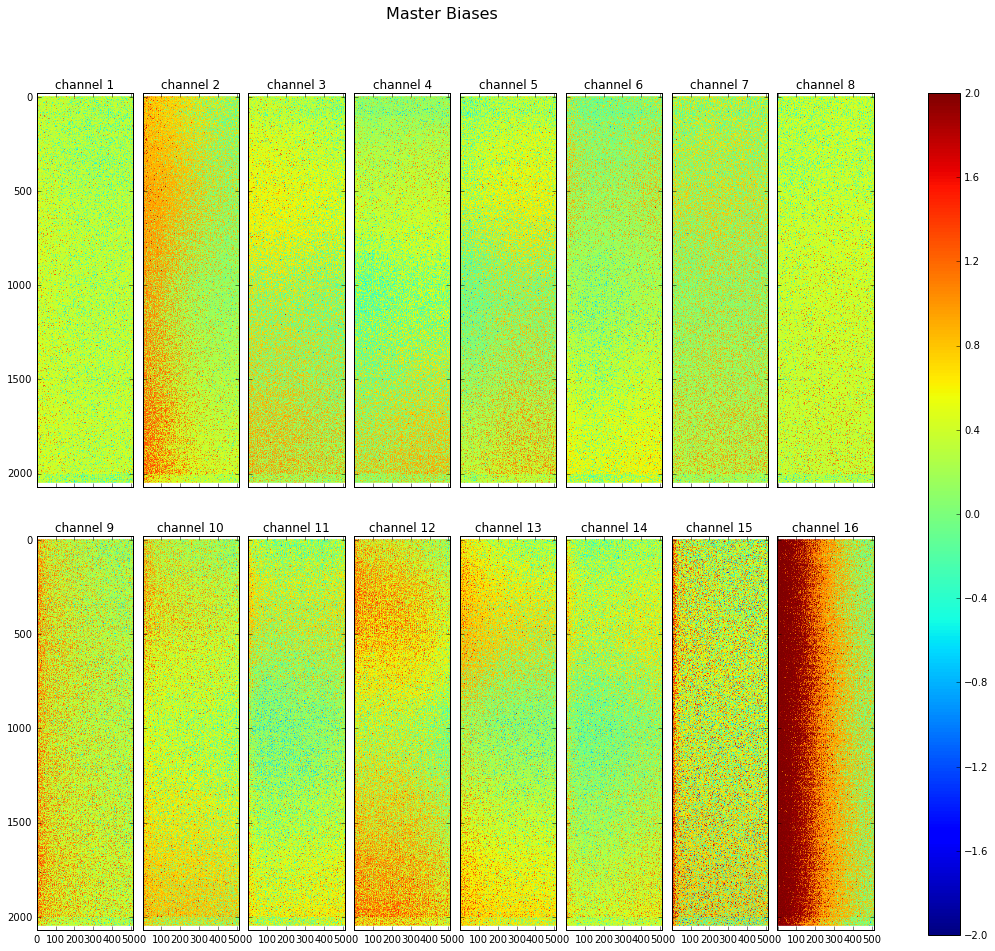

In [24]:
ShowMBImagesSet(masterbias_list)

In [25]:
def ShowMBHistoSet(masterbiaslist):
    '''
    Shows the whole set of CCD histograms
     - inputs argument:
       path : path of the fits file
       filename of the fits file
     - output the images of the whole CCD   
    '''
   
    
    NX=4 # number of images along the horizontal axis
    NY=4 # number of images along the vertical axis
    BIASMIN=-5.0
    BIASMAX=5.0
    BINWIDTH=0.25
    f, axarr = plt.subplots(NY,NX,figsize=(20,20)) # figure organisation
    #f, axarr = plt.subplots(NX,NY,sharex=True, sharey=True,figsize=(20,20))
    f.subplots_adjust(hspace=0.5,wspace=0.5)

    for index in range(NB_OF_CHAN_AMPL):  
        ix=index%4
        iy=index/4
        image_data = image_data = masterbiaslist[index].data
        data=image_data.flatten() # the data to process
        themean=np.mean(data)
        themedian=np.median(data)
        therms=np.std(data)
        label='mn = {:2.2f} md = {:2.2f} $\sigma$ = {:2.2f}'.format(themean,themedian,therms)
        axarr[iy,ix].hist(data,bins=np.arange(min(data), max(data) + BINWIDTH, BINWIDTH),facecolor='blue', alpha=0.75,log=True,label=label)  # plot the image
        #axarr[iy,ix].hist(data,bins=np.arange(min(data), max(data) + BINWIDTH, BINWIDTH),facecolor='blue', alpha=0.70,log=False)  # plot the image
        axarr[iy,ix].legend(loc='best')
        plottitle='channel {}'.format(index+1)
        axarr[iy,ix].set_xlim(BIASMIN,BIASMAX)
        axarr[iy,ix].set_ylim(100.,1e7)
        axarr[iy,ix].set_title(plottitle)
        axarr[iy,ix].set_xlabel('ADU')
        axarr[iy,ix].grid(True)
        #axarr[iy,ix].set_yscale('log')

    plt.yscale('log')
    title='Master Bias for combined biases with median substraction'
    plt.suptitle(title,size=16)
    plt.savefig('masterbias_ostrim_histos.pdf', bbox_inches='tight')

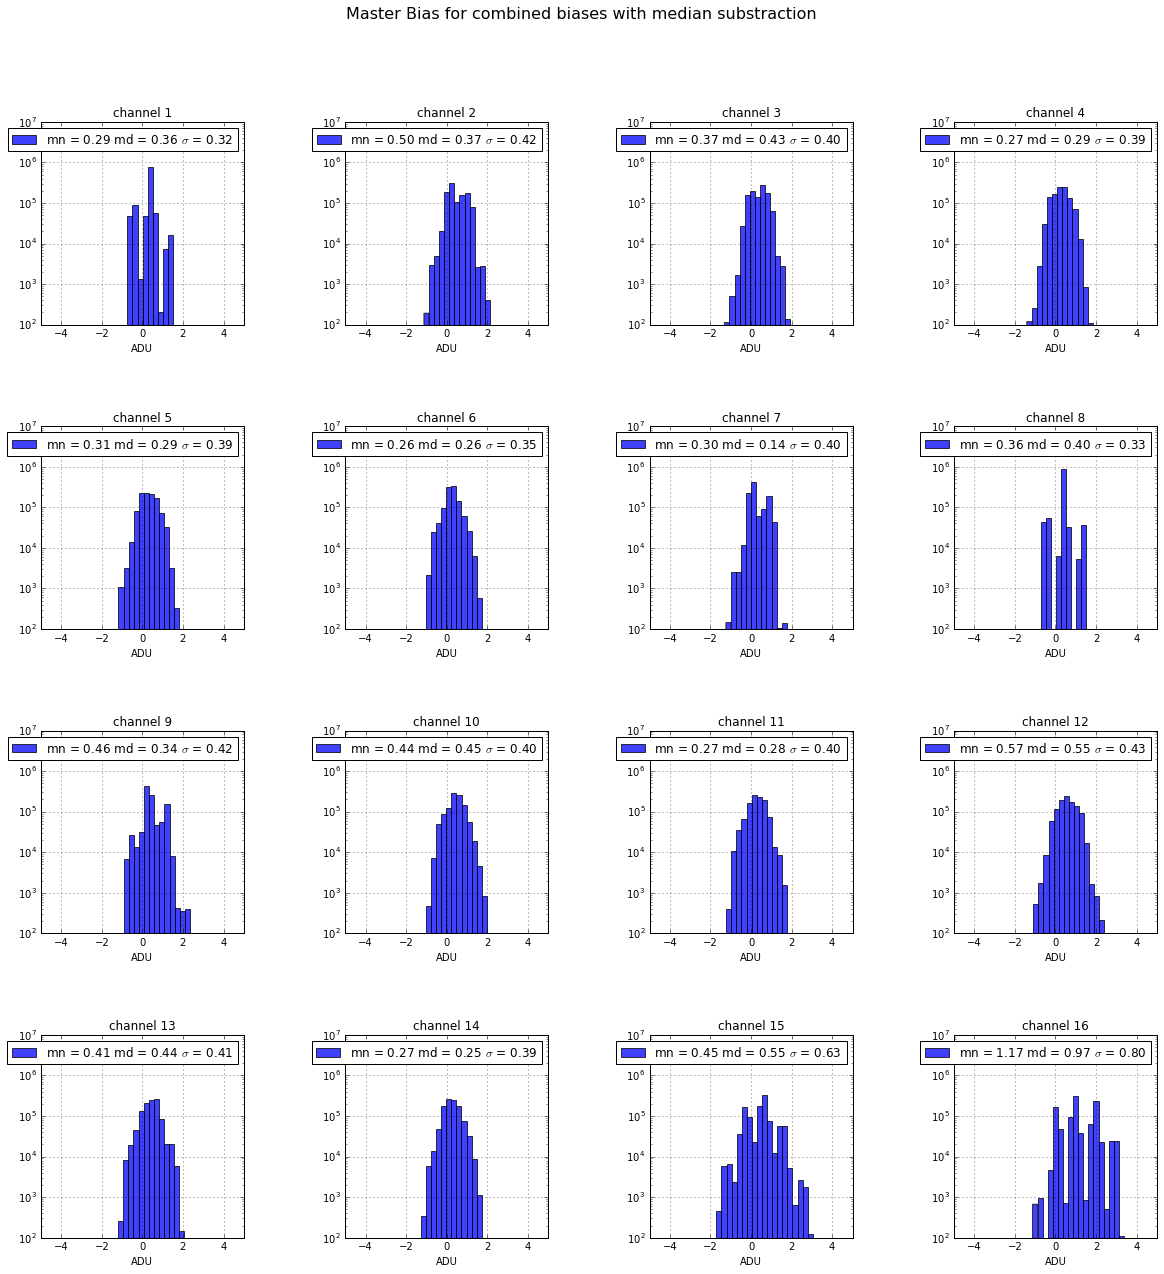

In [26]:
ShowMBHistoSet(masterbias_list)

### e) Save the masterbias file

In [27]:
monoc.SaveCCDListIntoFitsFile(masterbias_list,masterbias_out_filename,mbheader,imagetyp='master_bias')

Filename: (No file associated with this HDUList)
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       4   ()              
1                ImageHDU         7   (511, 2048)   float64   
2                ImageHDU         7   (511, 2048)   float64   
3                ImageHDU         7   (511, 2048)   float64   
4                ImageHDU         7   (511, 2048)   float64   
5                ImageHDU         7   (511, 2048)   float64   
6                ImageHDU         7   (511, 2048)   float64   
7                ImageHDU         7   (511, 2048)   float64   
8                ImageHDU         7   (511, 2048)   float64   
9                ImageHDU         7   (511, 2048)   float64   
10               ImageHDU         7   (511, 2048)   float64   
11               ImageHDU         7   (511, 2048)   float64   
12               ImageHDU         7   (511, 2048)   float64   
13               ImageHDU         7   (511, 2048)   float64   
14               Im

## 7.) Make some master darks
=======================================

### 7.1) Define the raw darks

In [28]:
root_darkfilename='mdark_'
dark_startnum=1
dark_stopnum=24

In [29]:
rawdark_list=BuildFilelist(path,root_darkfilename,start=dark_startnum,stop=dark_stopnum)

In [30]:
NB_OF_DARKS=len(rawdark_list)

In [31]:
allrawdark = []
for chan in range(1,NB_OF_CHAN_AMPL+1,1):
    ccd_chan = [ ccdproc.CCDData.read(image_file, hdu=chan,unit="adu") for image_file in rawdark_list ]
    allrawdark.append(ccd_chan)


In [32]:
masterdark_out_filename='masterdarkscaled_ostrim_1.fits' # scaled to 1 second
masterdark_out_filename_scaled='masterdarkscaled_ostrim_1.fits' # scaled to 1 second

### 7.2) Find the exposures

In [33]:
list_exposures=np.zeros(NB_OF_DARKS,dtype=np.float)

# loop on files
for file in range(NB_OF_DARKS):
    hdu_list = fits.open(rawdark_list[file])
    header=hdu_list[0].header
    number_of_channels=header['CHAN']
    exposure=header['EXPOSURE']
    list_exposures[file]=exposure

print list_exposures

[   1.    5.    7.   10.   20.   60.  120.  240.    1.    5.    7.   10.
   20.   60.  120.  240.    1.    5.    7.   10.   20.   60.  120.  240.]


In [34]:
exposure_values=np.array([1.,5.,7.,10.,20.,60.,120.,240.])
NB_EXPOSURES=exposure_values.shape[0]

In [35]:
exposure_file_indexes=[]
for exp in exposure_values:
    indexes_for_that_exposure=np.where(list_exposures==exp)
    exposure_file_indexes.append(indexes_for_that_exposure)

In [36]:
exposure_file_indexes

[(array([ 0,  8, 16]),),
 (array([ 1,  9, 17]),),
 (array([ 2, 10, 18]),),
 (array([ 3, 11, 19]),),
 (array([ 4, 12, 20]),),
 (array([ 5, 13, 21]),),
 (array([ 6, 14, 22]),),
 (array([ 7, 15, 23]),)]

### 7.3 prepare for computation of darks masters

More complicated than the bias frames because we will:

- subtract overscan
- trim
- sigma clip the image stack to remove outliers
- combine using median

This will be done NB_EXPOSURES, once for each  of the NB_EXPOSURES in the raw darks


#### a. Define convenient function (optional, justification below)¶

I'll make NB_EXPOSURES master darks  for calibrating science frames

In [37]:
def overscan_trim_and_sigma_clip_median(image_list, clip_baseline_func=med_over_images):
    """
    Combine a list of images using median
    
    This function does several steps:
    
    1. Subtract overscan
    2. Trim image
    3. sigma clip image using a median of the unclipped stack as the baseline
    4. combine the images on the list using median
    
    ** It modifies the images in the input list. **
    """
    oscan_and_trim(image_list)
    combo = ccdproc.Combiner(image_list)
    combo.sigma_clipping(func=clip_baseline_func)
    return combo

#### b. Make CCDData objects for darks and reduce

In [38]:
def ComputeMasterDark(channel):
    '''
    Function to compute the Master Dark for each of the CCD amplifier channels 
    input: 
        channel : id number of the channel amplifier
    output:
        master dark and combiner list for all exposures and for this channel.
    '''    
    
    #print 'compute Master Darks for channel ',channel
    
    master_darks = {}  # output dictionnary
    combiners = {}     # output dictionnary
    
    exposure_index=0  # to have the correcponding index in the exposure_values list
    # loop on each of Exposure times
    

    for exposure in exposure_values:
        fileindexes=exposure_file_indexes[exposure_index][0]
        #print 'exposure', exposure_index,' exposure_value = ',exposure, 'fileindexes=',fileindexes
    
        
        # make list of darks with this exposure time
        a_list = []
        
        # Loop on files of the current exposure, by the file index
        for fileindex in fileindexes:
            fname=os.path.basename(rawdark_list[fileindex])  # get the filename to check
            #print '   - fileindex=',fileindex, 'fname=',fname
            therawdark=allrawdark[channel][fileindex]  # retrieve the dark for that exposure and that exposure
            meta = therawdark.header  # copy the dark header
            meta['filename'] = fname  # put the dark filename
            therawdark.data
            a_list.append(ccdproc.CCDData(therawdark.data, meta=meta, unit="adu")) # add this dark to the dark list
            
        # get the exposure time as it appears in the fits file for use as a dictionary key
        #exposure_time_in_fits_file = a_list[0].header['EXPOSURE']
        #print '* check exposure in fits file  exposure_time_in_fits_file ',  exposure_time_in_fits_file
        
        # make a combiner for sigma clipping and median combine
        a_combiner = overscan_trim_and_sigma_clip_median(a_list)
        combiners[exposure] = a_combiner
        master_darks[exposure] = a_combiner.median_combine(median_func=bn_median)

        # set the exposure time in the master -- right now combiner doesn't attempt to combine meta
        master_darks[exposure].header['exptime'] = exposure
        #print "For channel {} For exposure {} seconds, there are {} bad pixels in the dark master.".format(channel+1,exposure,master_darks[exposure].mask.sum())
        exposure_index=exposure_index+1
        
    return master_darks,combiners

## 7.3) Calculate the Master Darks for each exposure and each channel

### 7.3.1) Overscan substraction, Triming, Combination of equal exposure darks 


This is very important that each exposure is processed indpendently

In [39]:
all_master_darks = []  # list of resulting master-dark-list  one per channel
for chan in range(NB_OF_CHAN_AMPL):
    md_dict,cmb_list=ComputeMasterDark(chan)   
    all_master_darks.append(md_dict)

### 7.3.2) Dark-Master - Master-Bias substraction

#### indexing channel, exposure

In [40]:
all_master_darks_subbias=[] # list per channel of exposure dictionnaries of Master-Dark subtracted by  
for chan in range(NB_OF_CHAN_AMPL):
    master_darks_subbias = {}  # output one dictionnary, index is the exposure time
    # compute dictionaries of corrected darks
    for expo in list_exposures:
        master_darks_subbias[expo]=ccdproc.subtract_bias(all_master_darks[chan][expo],masterbias_list[chan])
        
    all_master_darks_subbias.append(master_darks_subbias)

In [41]:
len(all_master_darks_subbias)

16

#### exposure, indexing channel

In [42]:
all_master_darks_subbias_perexpo = {}   # dictionnary  per exposure of Master-Darks list by channels
for expo in list_exposures:
    master_darks_subbias_perexpo = []
    for chan in range(NB_OF_CHAN_AMPL):
        md_sb=all_master_darks_subbias[chan][expo]
        master_darks_subbias_perexpo.append(md_sb)
    all_master_darks_subbias_perexpo[expo]= master_darks_subbias_perexpo
        

In [43]:
len(all_master_darks_subbias_perexpo)

8

In [44]:
def ShowMasterDarkHistoSet(masterdarks, exposure):
    '''
    Shows the whole set of CCD histograms
     - inputs argument:
       path : path of the fits file
       filename of the fits file
     - output the images of the whole CCD   
    '''
       
    NX=4 # number of images along the horizontal axis
    NY=4 # number of images along the vertical axis
    DARKMIN=-10
    DARKMAX=80
    BINWIDTH=0.25
    f, axarr = plt.subplots(NY,NX,figsize=(13,13)) # figure organisation
    
    f.subplots_adjust(hspace=0.5,wspace=0.5)

    for index in range(NB_OF_CHAN_AMPL):  
        ix=index%4
        iy=index/4
        image_data = masterdarks[index][exposure].data[0:2000,:]
        data=image_data.flatten()
        print 'channel = ', index+1,' exposure =',exposure,' sec, darks mean =',data.mean(),' darks rms', data.std()
        label='m={:3.2f} $\sigma$={:3.2f}'.format(data.mean(),data.std())
        axarr[iy,ix].hist(data,bins=np.arange(min(data), max(data) + BINWIDTH, BINWIDTH),facecolor='blue', alpha=0.75,log=True,label=label)  # plot the image
        #axarr[iy,ix].hist(data,bins=np.arange(min(data), max(data) + BINWIDTH, BINWIDTH),facecolor='blue', alpha=0.70,log=False)  # plot the image
        plottitle='channel {}'.format(index+1)
        axarr[iy,ix].set_xlim(DARKMIN,DARKMAX)
        axarr[iy,ix].set_ylim(1.,1e6)
        axarr[iy,ix].set_title(plottitle)
        axarr[iy,ix].set_xlabel('ADU')
        axarr[iy,ix].grid(True)
        axarr[iy,ix].legend(loc='best')
        #axarr[iy,ix].set_yscale('log')

    plt.yscale('log')
    title='Master Darks for exposure {} seconds '.format(exposure)
    plt.suptitle(title,size=16)
    figfilename='masterdarks_ostrim_histos_expo_'+str(exposure)+'.pdf'
    plt.savefig(figfilename, bbox_inches='tight')
   

In [45]:
exposure_values

array([   1.,    5.,    7.,   10.,   20.,   60.,  120.,  240.])

In [46]:
#all_master_darks_subbias[10]

masterdarkscaled_ostrim_exposure1sec.pdf
channel =  1  exposure = 1.0  sec, darks mean = -0.219686845708  darks rms 1.17015560409
channel =  2  exposure = 1.0  sec, darks mean = -0.0967855523116  darks rms 1.14681040584
channel =  3  exposure = 1.0  sec, darks mean = -0.291988076707  darks rms 1.19447394221
channel =  4  exposure = 1.0  sec, darks mean = -0.302952586367  darks rms 1.14702811733
channel =  5  exposure = 1.0  sec, darks mean = -0.468070194016  darks rms 1.20564963145
channel =  6  exposure = 1.0  sec, darks mean = -0.248263878066  darks rms 1.1279615456
channel =  7  exposure = 1.0  sec, darks mean = -0.295434115142  darks rms 1.17518291746
channel =  8  exposure = 1.0  sec, darks mean = -0.369461042265  darks rms 1.113920226
channel =  9  exposure = 1.0  sec, darks mean = -0.397738673427  darks rms 1.4299967535
channel =  10  exposure = 1.0  sec, darks mean = -0.59148799735  darks rms 1.35248853623
channel =  11  exposure = 1.0  sec, darks mean = -0.33427569399  darks r

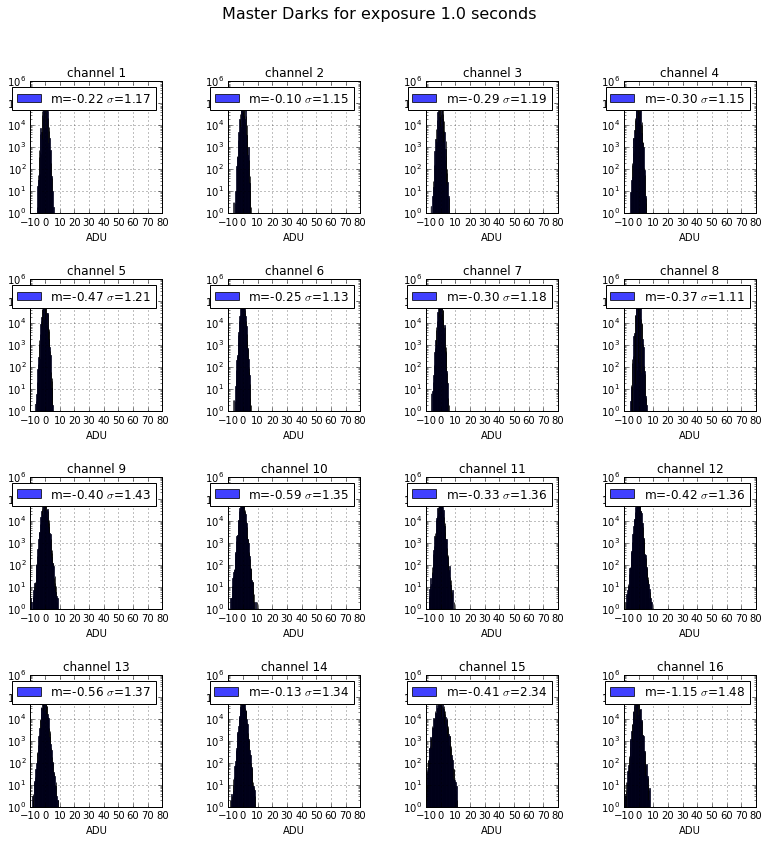

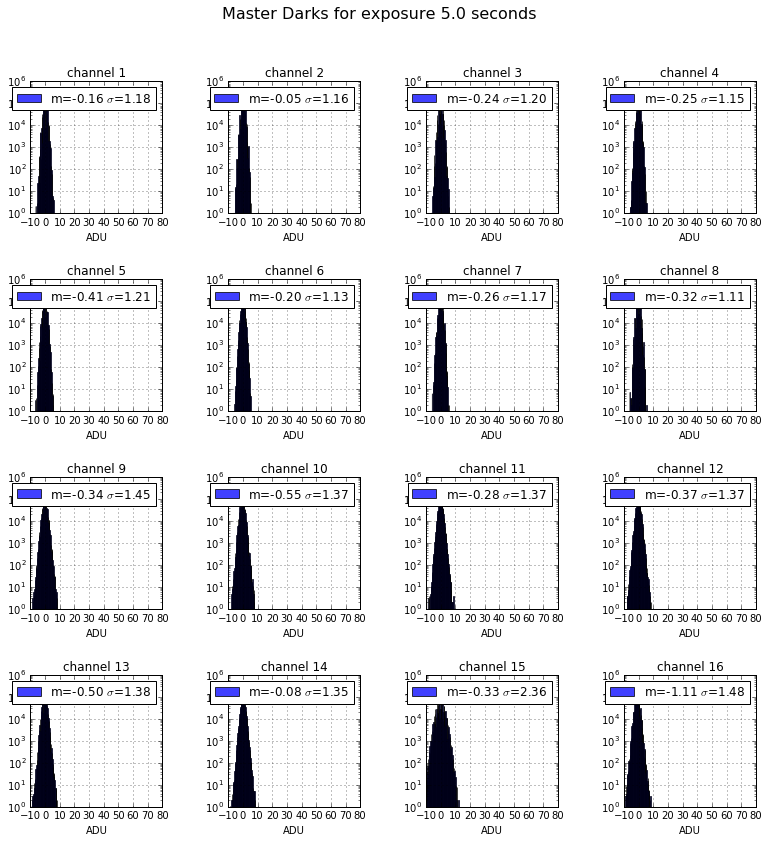

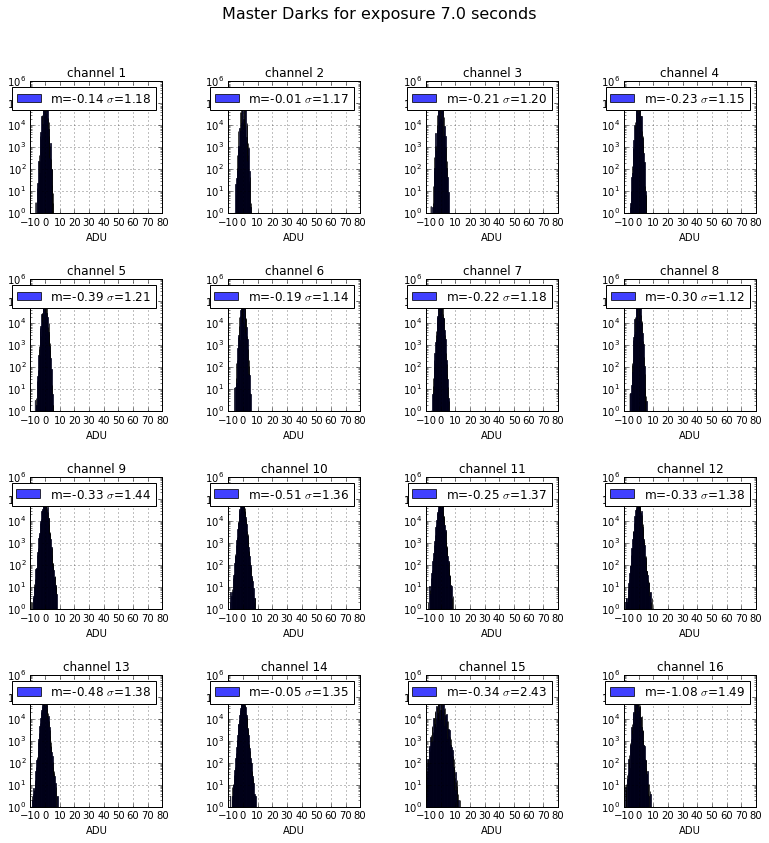

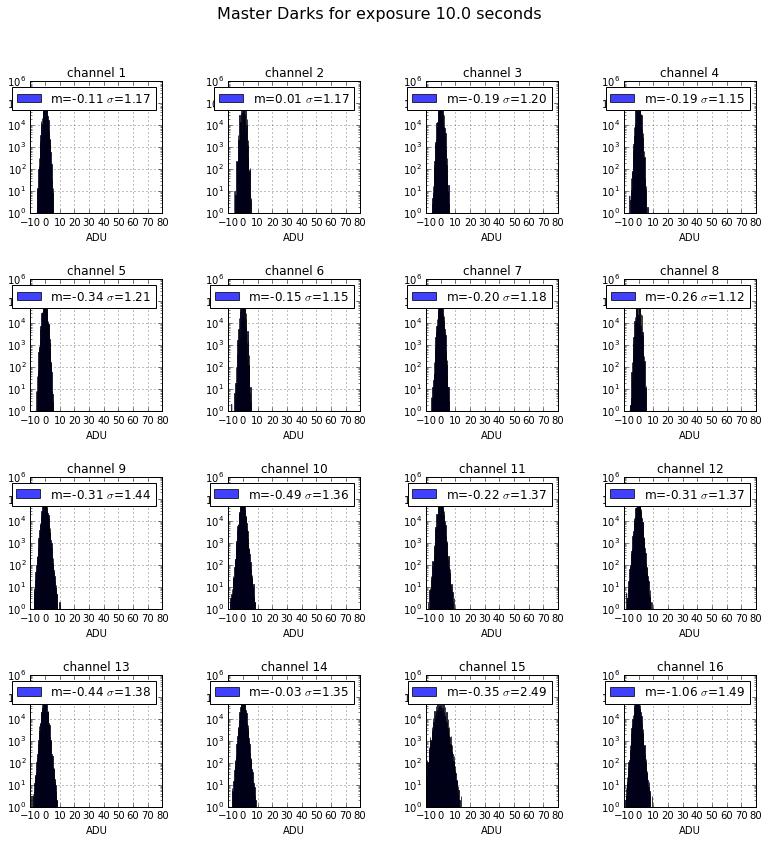

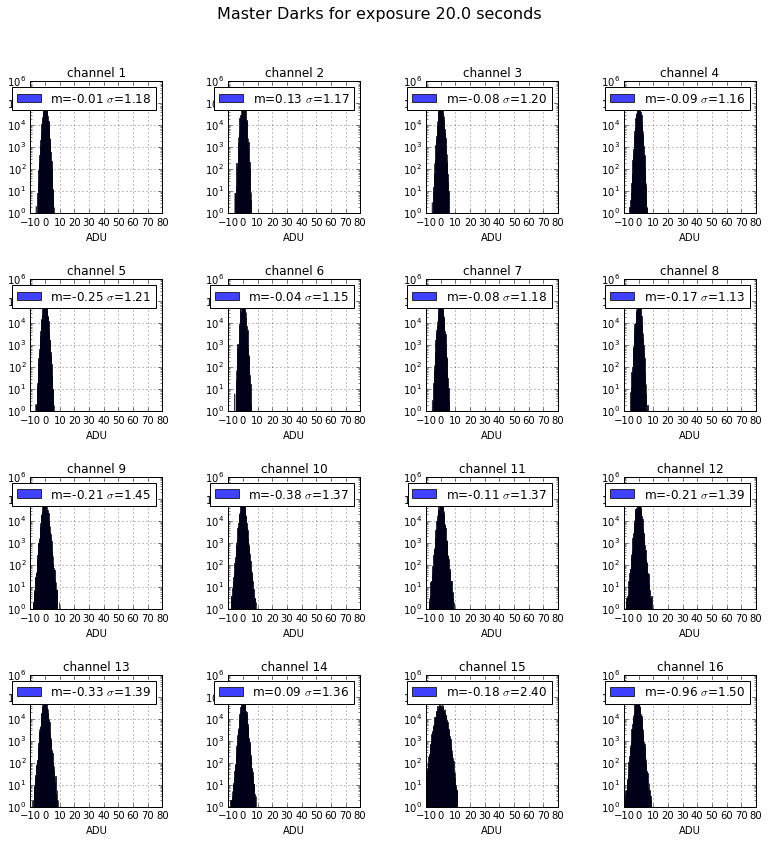

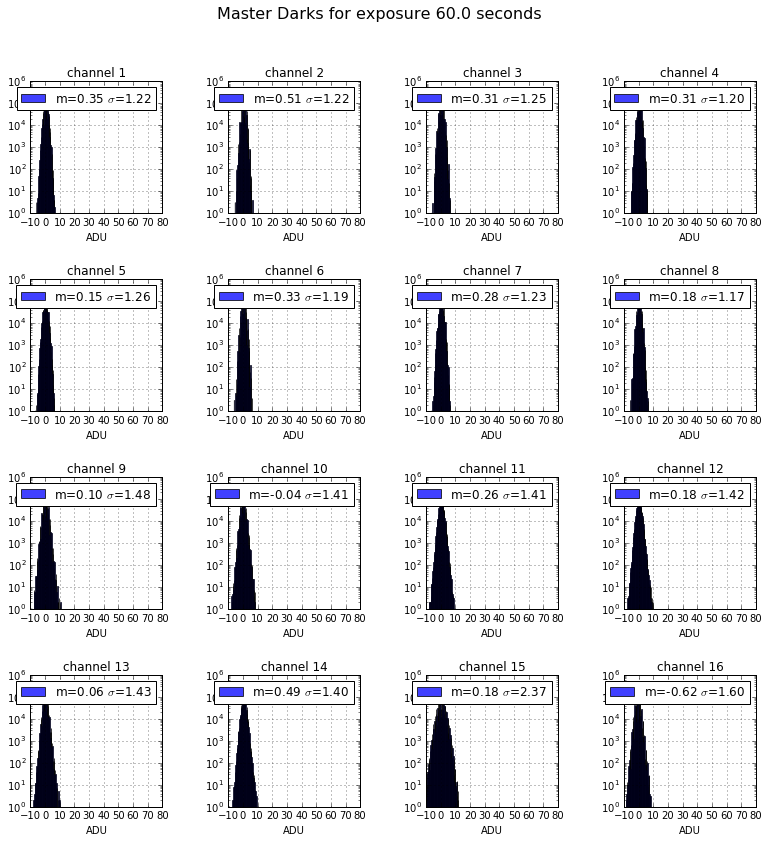

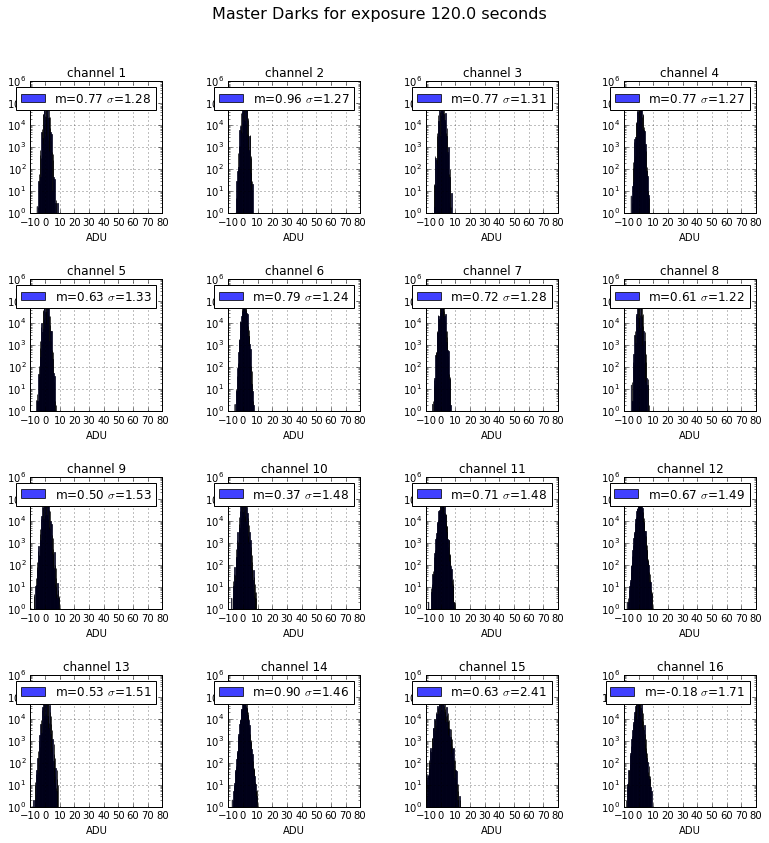

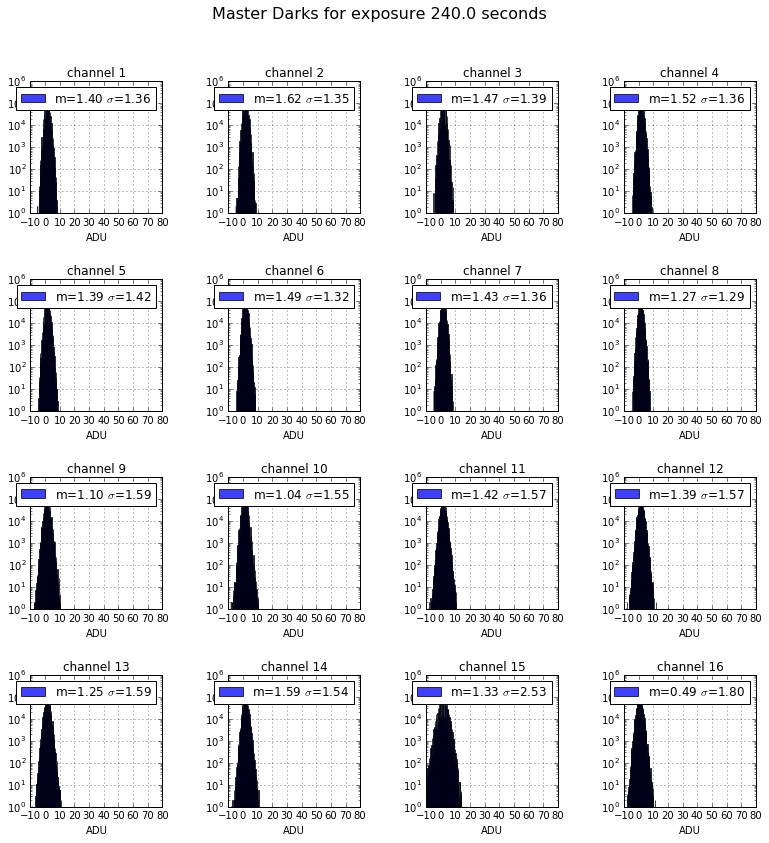

In [47]:
for exposure in exposure_values:
    masterdark_hist_filename='masterdarkscaled_ostrim_exposure{:d}sec.pdf'.format(int(exposure))
    print masterdark_hist_filename
    basefilename=root_darkfilename+'XX.fits'
    histtitle='Masterdark distributions for Exposure {:3.0f} seconds'.format(exposure)
    ShowMasterDarkHistoSet(all_master_darks_subbias,exposure)
    #monoc.ShowHistoSet(all_master_darks_subbias,histtitle,basefilename,masterdark_hist_filename)
    #ShowHistoSet(ccdlist,maintitle,datafile,figfile,nbsig=3.)

#### WORK

In [48]:
for exposure in exposure_values: 
    masterdark_out_filename='masterdarks_ostrim_sb_exposure{:d}sec.fits'.format(int(exposure))
    masterdark_out_histfilename='masterdarks_ostrim_sb_exposure{:d}sec.pdf'.format(int(exposure))
    print masterdark_out_filename
    monoc.SaveCCDListIntoFitsFile(all_master_darks_subbias_perexpo[exposure],masterdark_out_filename,mbheader,imagetyp='master_dark')
    #histotitle='Master Darks corrected from bias at exprosure {} seconds'.format(exposure)
    #monoc.ShowHistoSet(all_master_darks_subbias_perexpo[exposure],histotitle,root_darkfilename,masterdark_out_histfilename,nbsig=3.)

masterdarks_ostrim_sb_exposure1sec.fits
Filename: (No file associated with this HDUList)
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       4   ()              
1                ImageHDU         7   (511, 2048)   float64   
2                ImageHDU         7   (511, 2048)   float64   
3                ImageHDU         7   (511, 2048)   float64   
4                ImageHDU         7   (511, 2048)   float64   
5                ImageHDU         7   (511, 2048)   float64   
6                ImageHDU         7   (511, 2048)   float64   
7                ImageHDU         7   (511, 2048)   float64   
8                ImageHDU         7   (511, 2048)   float64   
9                ImageHDU         7   (511, 2048)   float64   
10               ImageHDU         7   (511, 2048)   float64   
11               ImageHDU         7   (511, 2048)   float64   
12               ImageHDU         7   (511, 2048)   float64   
13               ImageHDU         7   (511

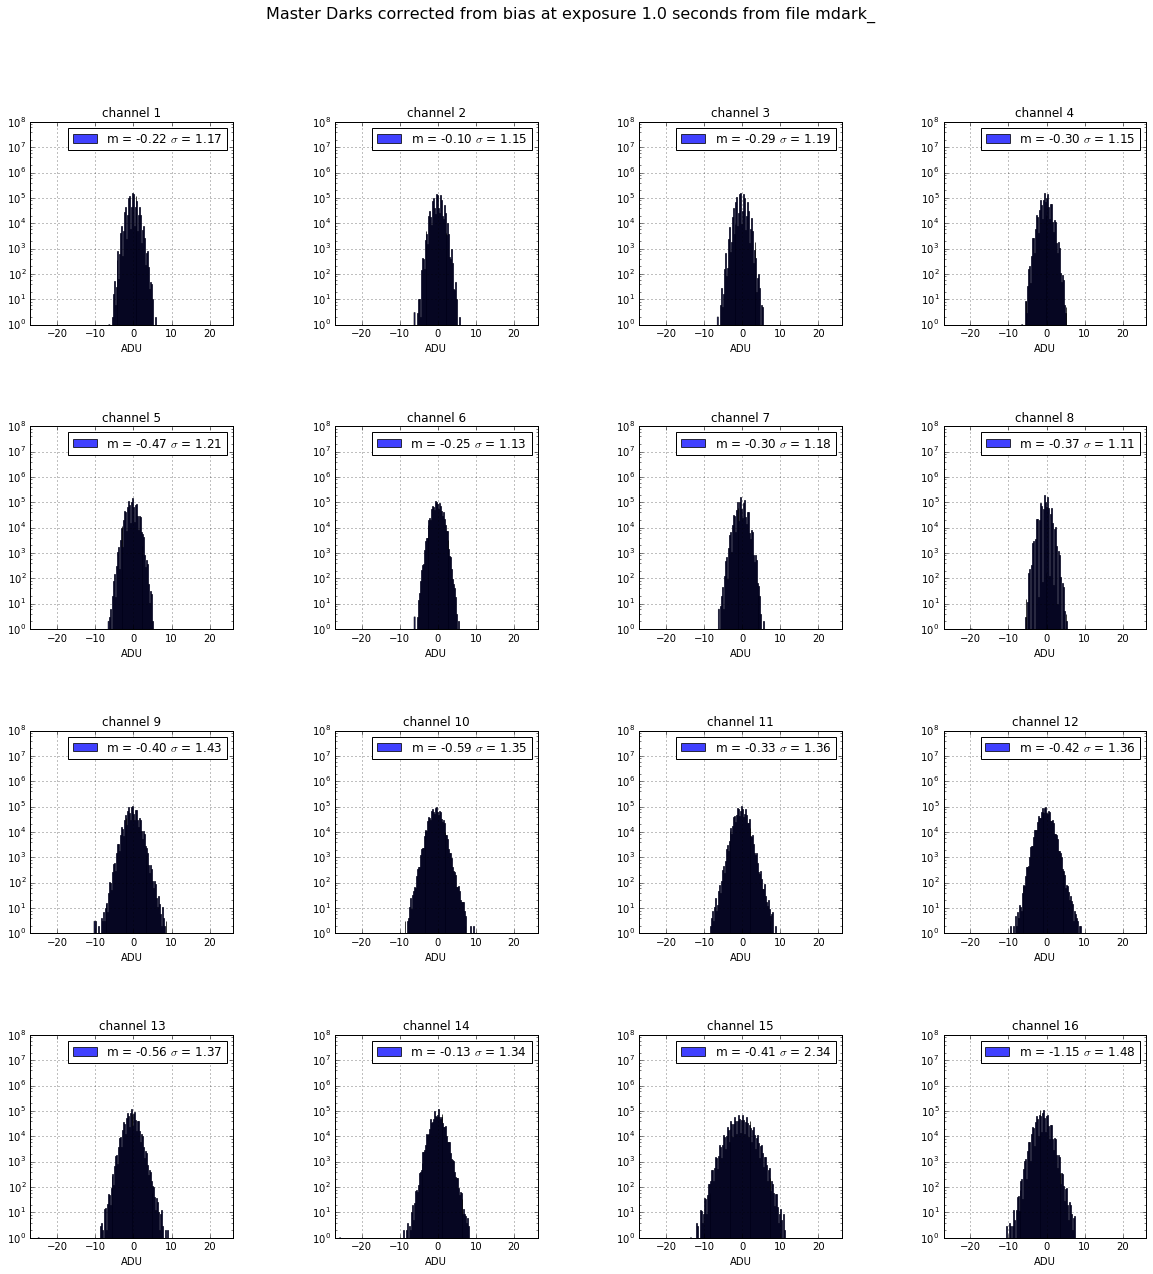

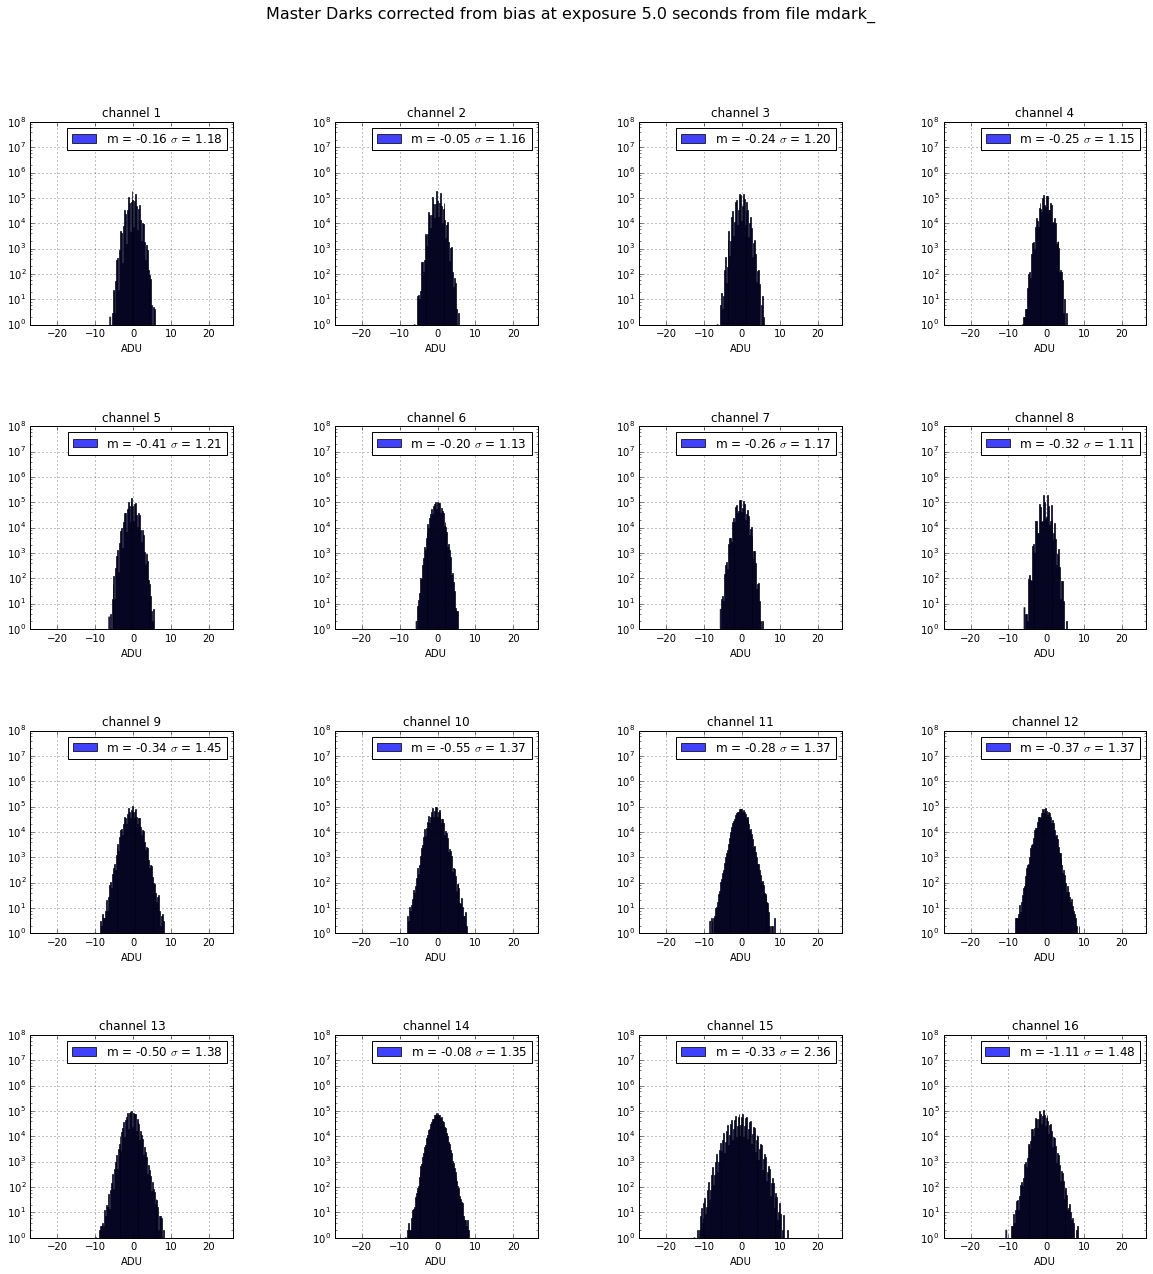

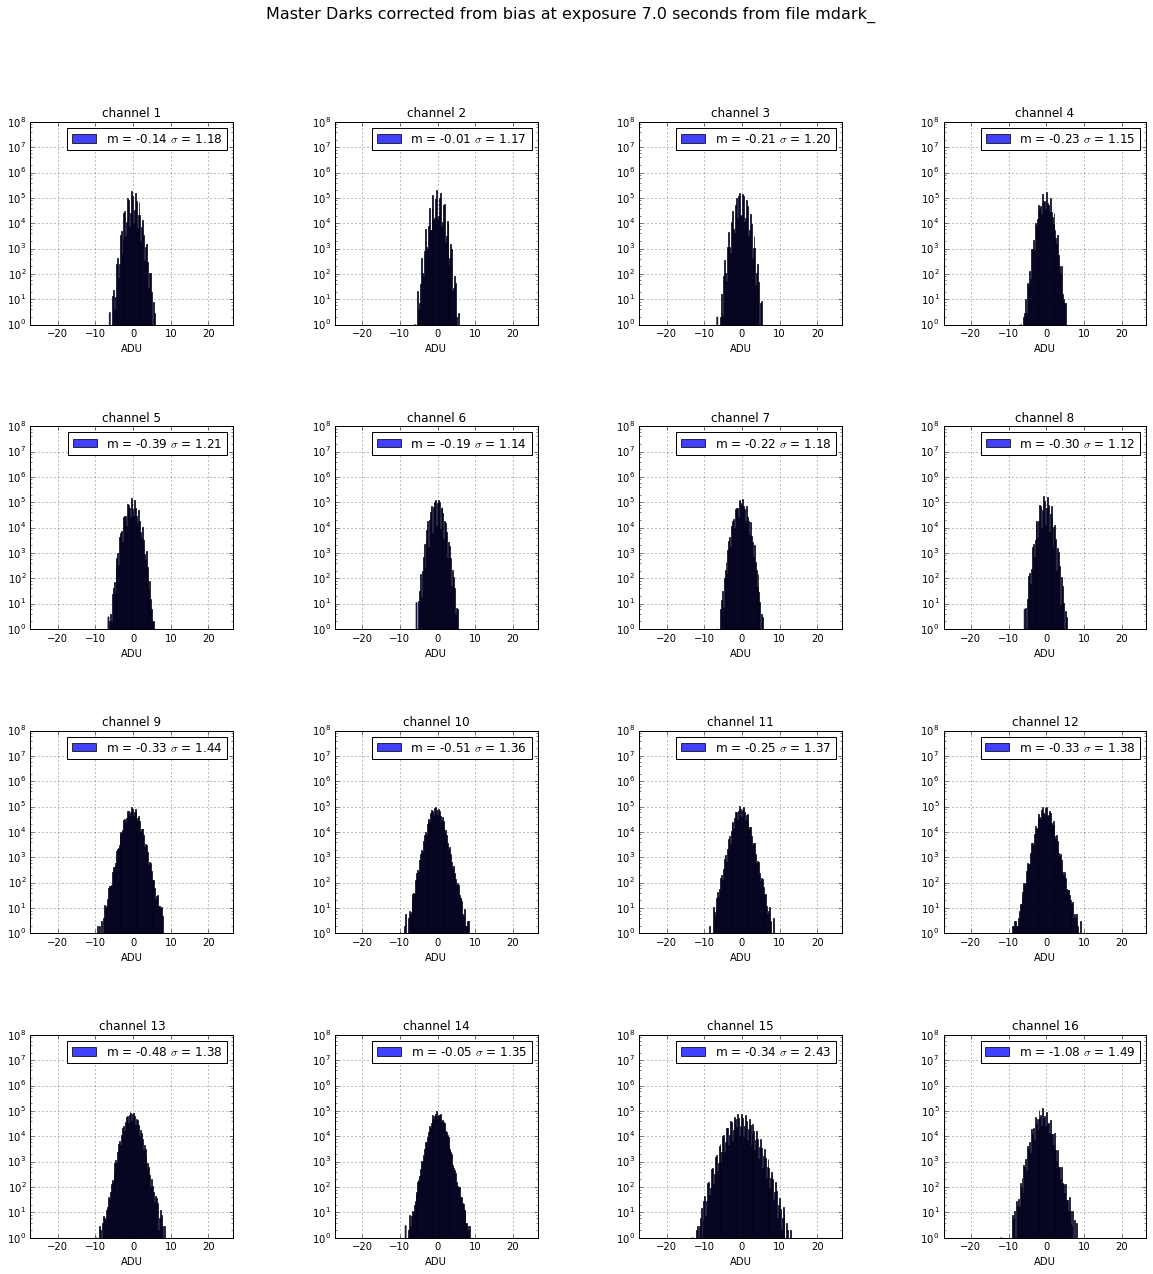

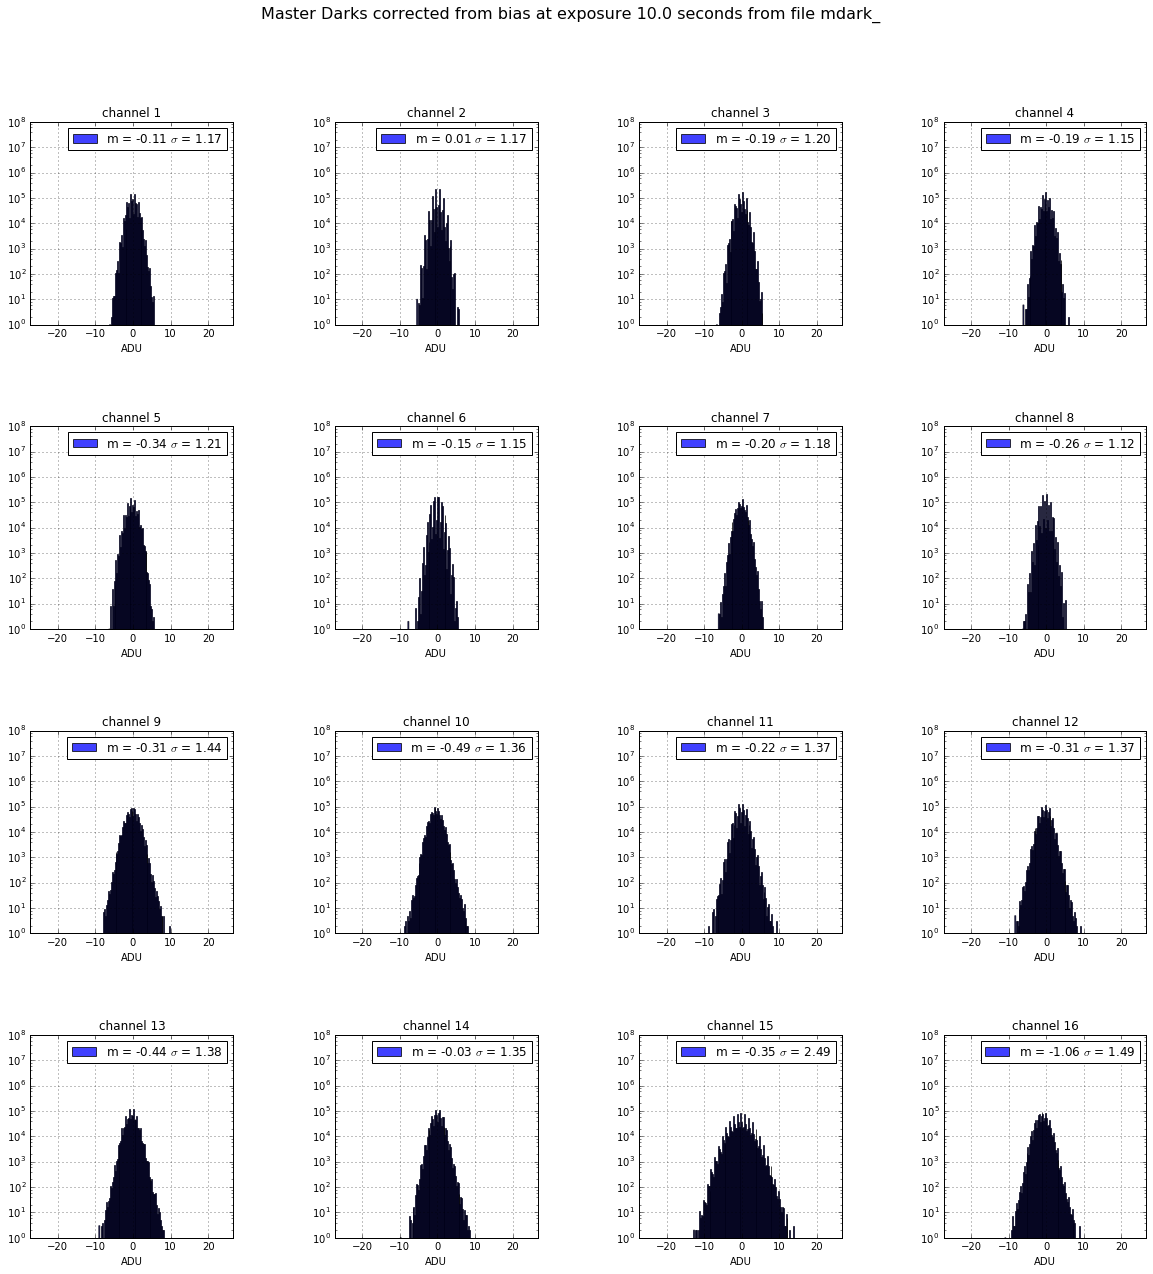

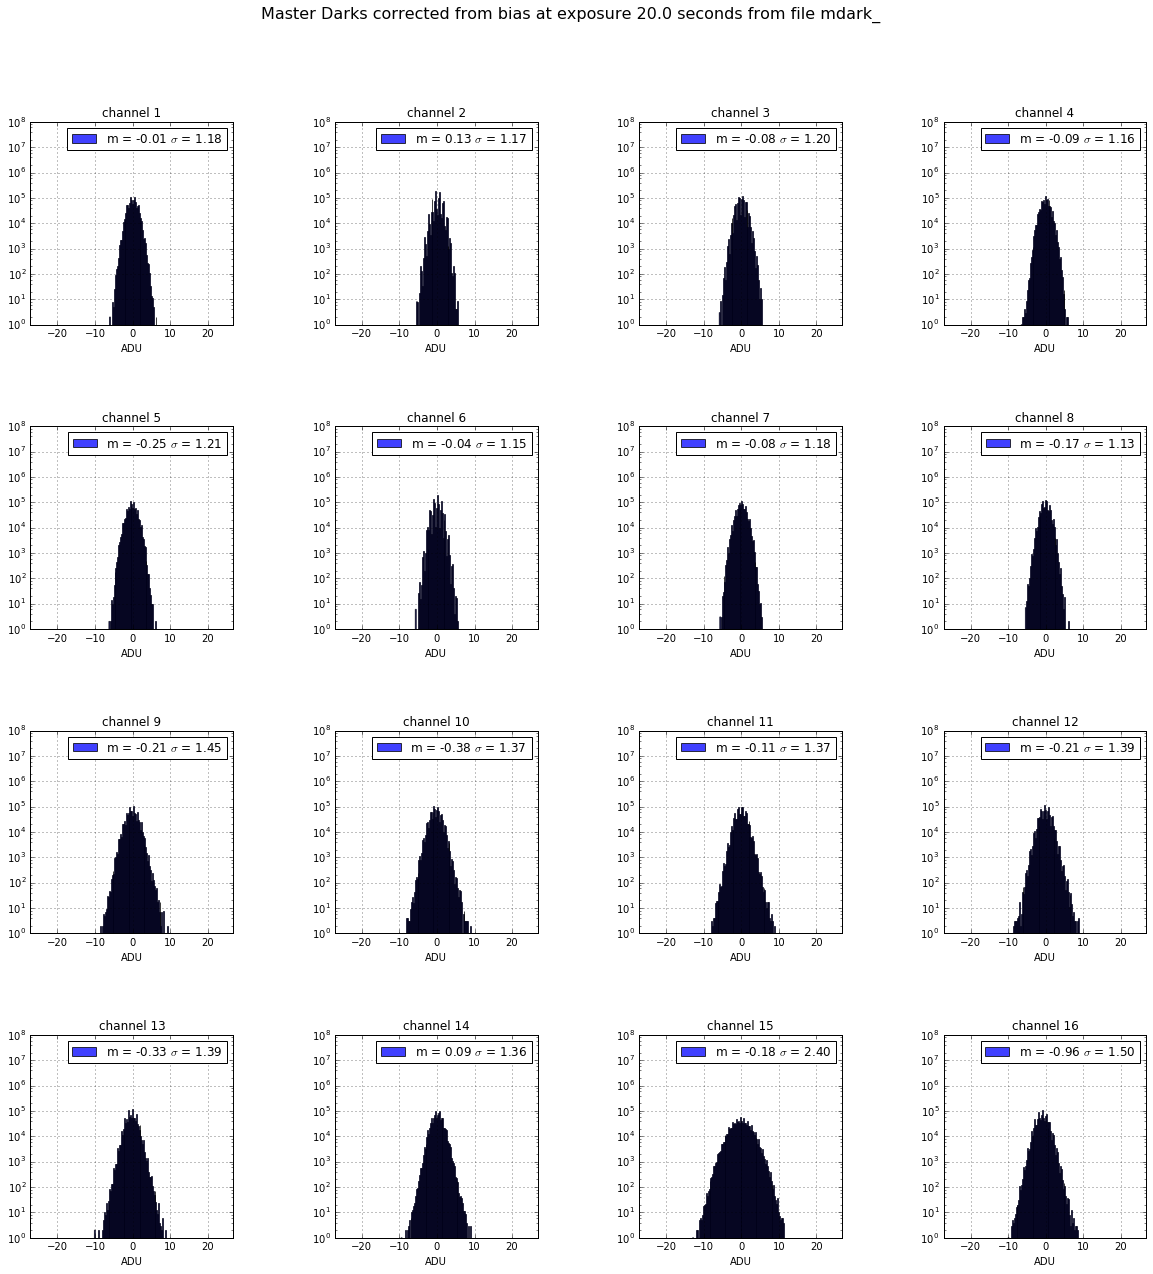

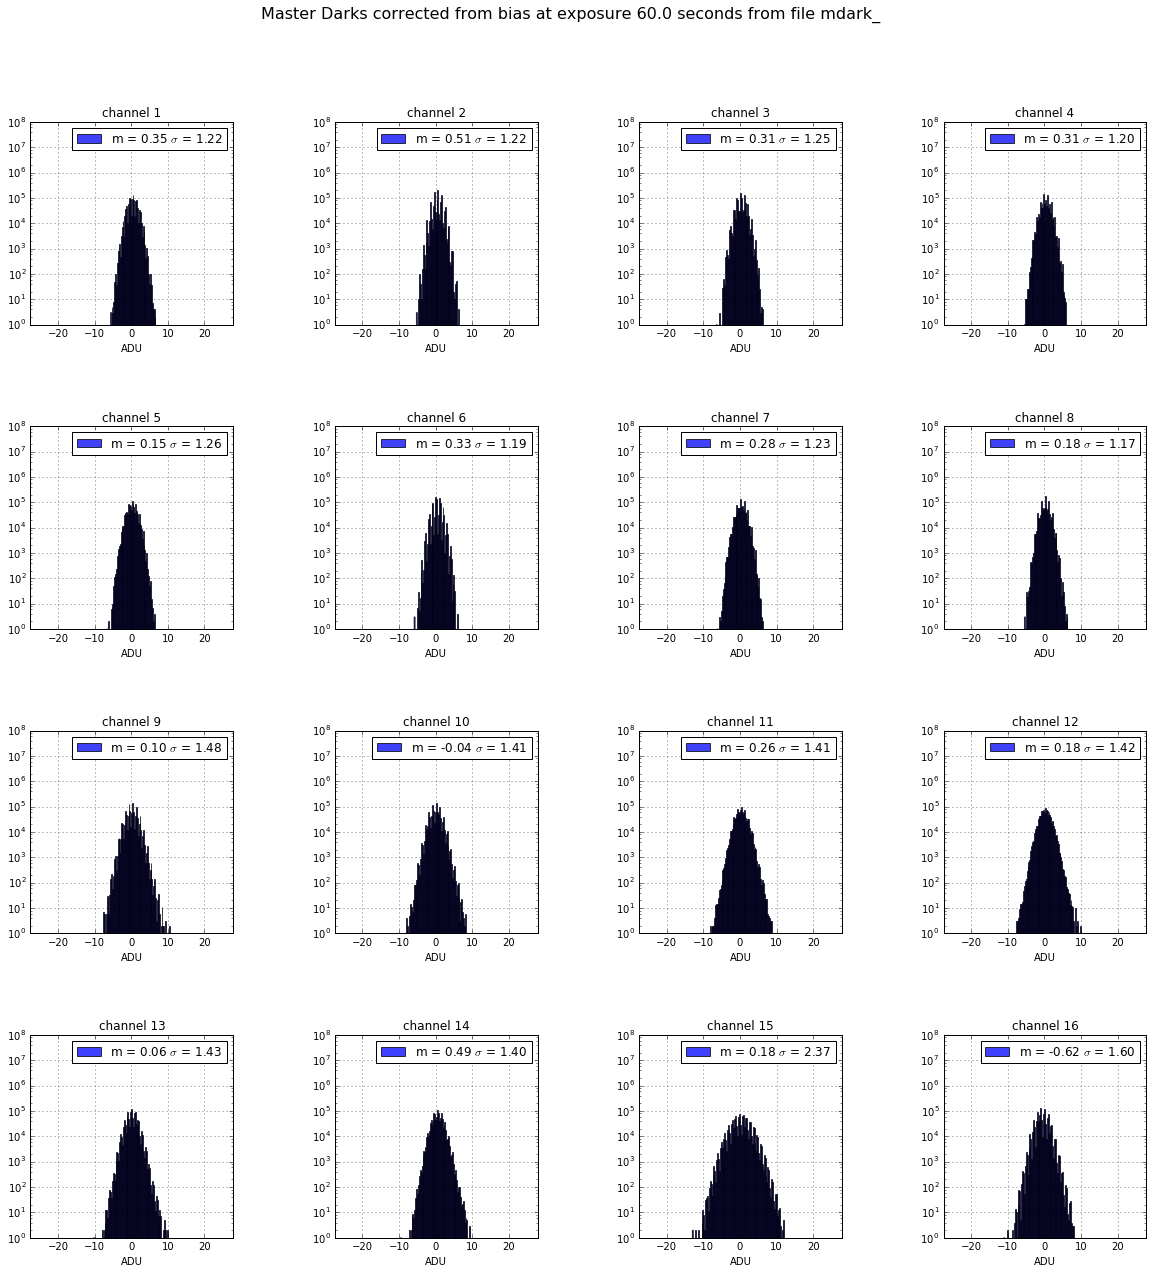

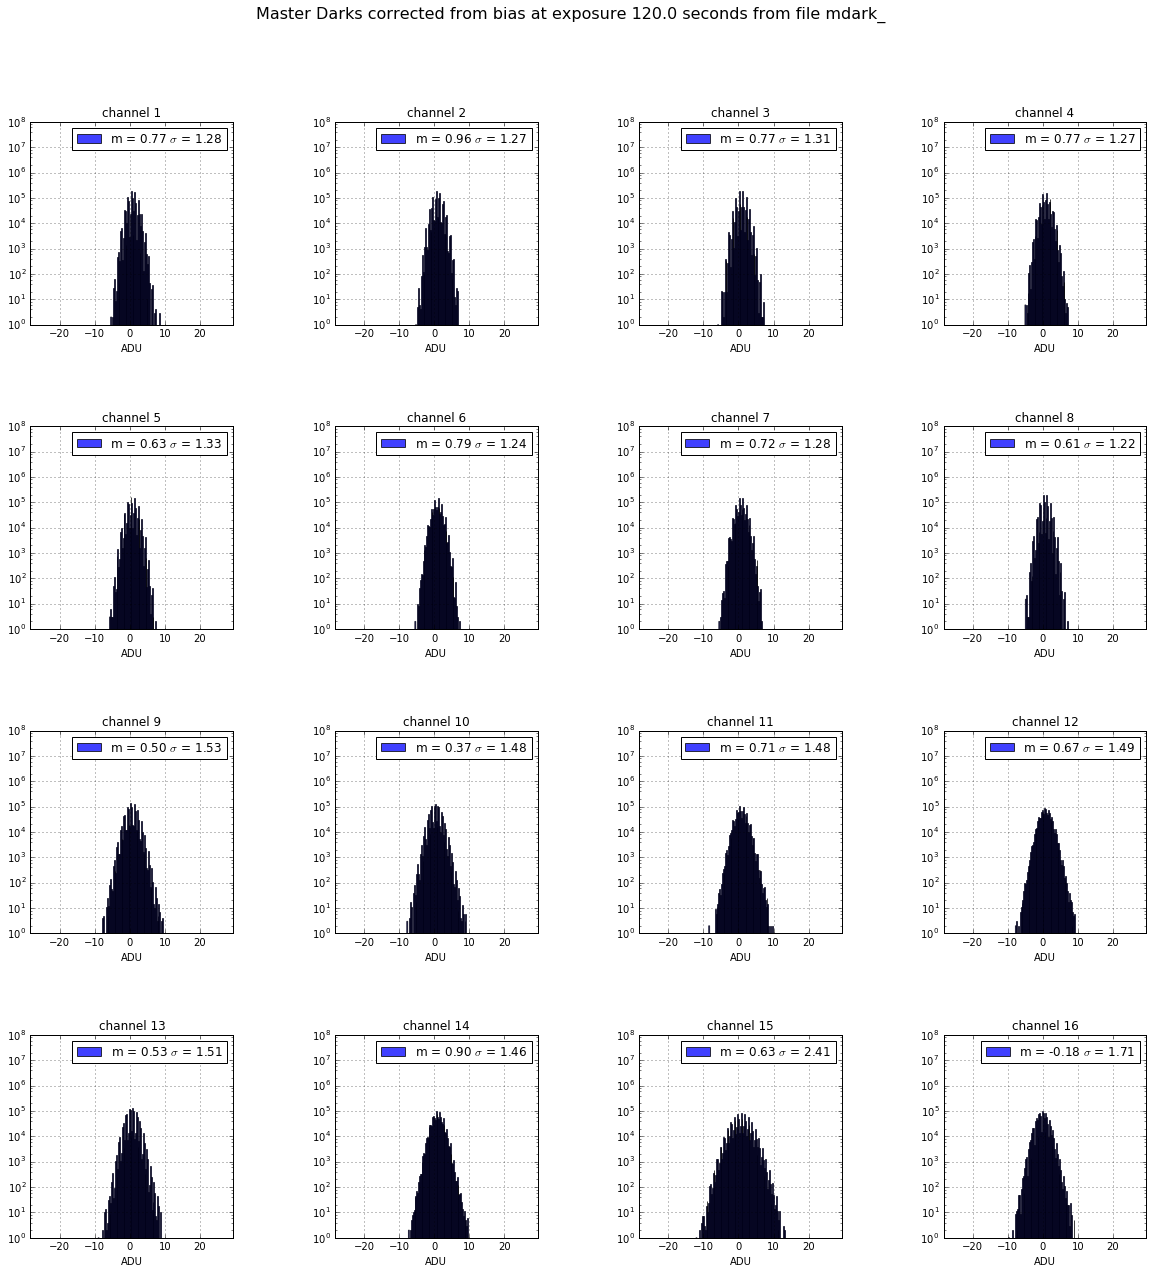

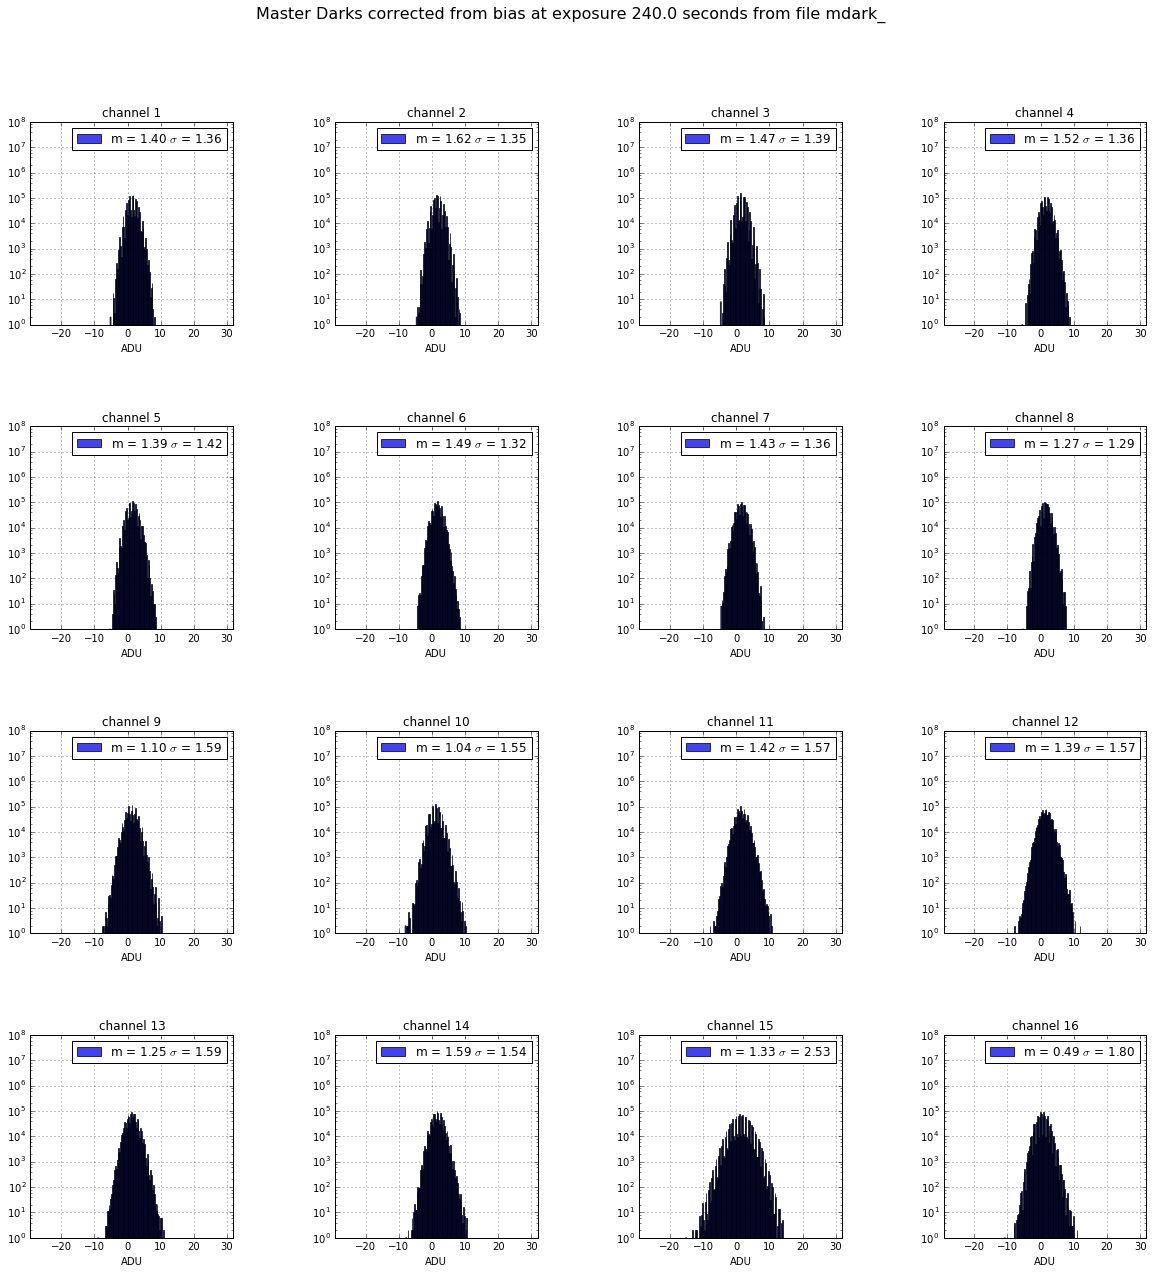

In [49]:
for exposure in exposure_values: 
    masterdark_out_histfilename='masterdarks_ostrim_sb_exposure{:d}sec.pdf'.format(int(exposure))  
    histotitle='Master Darks corrected from bias at exposure {} seconds'.format(exposure)
    monoc.ShowHistoSet(all_master_darks_subbias_perexpo[exposure],histotitle,root_darkfilename,masterdark_out_histfilename,nbsig=20.)

In [50]:
for exposure in exposure_values: 
    masterdark_out_filename_scaled='masterdarks_ostrim_sb_exposure{:d}sec.fits'.format(int(exposure))
    print masterdark_out_filename_scaled
    monoc.SaveCCDListIntoFitsFile(all_master_darks_subbias_perexpo[exposure],masterdark_out_filename_scaled,mbheader,imagetyp='master_dark')

masterdarks_ostrim_sb_exposure1sec.fits
Filename: (No file associated with this HDUList)
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       4   ()              
1                ImageHDU         7   (511, 2048)   float64   
2                ImageHDU         7   (511, 2048)   float64   
3                ImageHDU         7   (511, 2048)   float64   
4                ImageHDU         7   (511, 2048)   float64   
5                ImageHDU         7   (511, 2048)   float64   
6                ImageHDU         7   (511, 2048)   float64   
7                ImageHDU         7   (511, 2048)   float64   
8                ImageHDU         7   (511, 2048)   float64   
9                ImageHDU         7   (511, 2048)   float64   
10               ImageHDU         7   (511, 2048)   float64   
11               ImageHDU         7   (511, 2048)   float64   
12               ImageHDU         7   (511, 2048)   float64   
13               ImageHDU         7   (511

In [51]:
def ShowMasterDarkCurve(masterdarks):
    '''
    ShowMasterDarkCurve(masterdarks):
    
    masterdark : list of average darks versus exposure
    
    '''
       
    NX=1 # number of images along the horizontal axis
    NY=1 # number of images along the vertical axis
    f, axarr = plt.subplots(NY,NX,figsize=(10,10)) # figure organisation

    
    
    for index in range(NB_OF_CHAN_AMPL):      
        numchan=index
        label='channel {}'.format(index+1)
        
        darks_mean=np.zeros(len(list_exposures))
        darks_rms=np.zeros(len(list_exposures))
        darks_expo=np.zeros(len(list_exposures))
        
        expo_index=0
        
        for expo in list_exposures:
            image_data = masterdarks[index][expo].data[0:2000,:]
            
            darks_mean[expo_index]=(image_data.flatten()).mean()
            darks_rms[expo_index]=(image_data.flatten()).std()
            darks_expo[expo_index]=expo
            
            expo_index=expo_index+1
            
        plt.plot(list_exposures,darks_mean,'o-',label=label)
    
    plt.ylabel('ADU')
    plt.xlabel('Exposure (s)')
    plt.grid(True)
    plt.legend(loc='best')

    title='Average Dark corrected from bias versus exposure'
    plt.suptitle(title,size=16)
    plt.savefig('masterdark_ostrim_curve.pdf', bbox_inches='tight')
    plt.show()



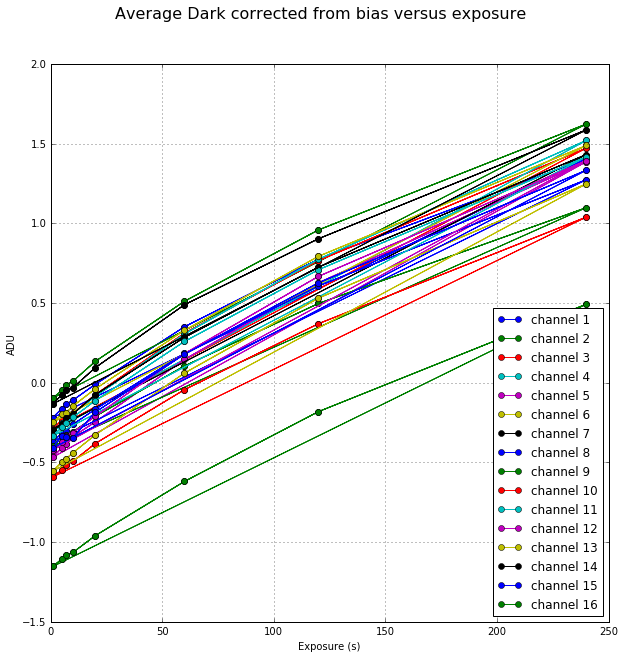

In [52]:
ShowMasterDarkCurve(all_master_darks_subbias)

### 7.3.3) Combine all darks exposures 

- Now combines all darks given the fact they scale with exposure.
- Every darks normalised to 1 second exposure.

In [53]:
all_master_darks_exposcaled=[]
invexpo=1./exposure_values
for chan in range(NB_OF_CHAN_AMPL):
    combined_master_darks_sb = [] 
    for idexp,expo in enumerate(list_exposures):
        #timenormaliseddark=all_master_darks_subbias[chan][expo].data/expo   # normalise to 1 second exposure     
        #combined_master_darks_sb.append(ccdproc.CCDData(timenormaliseddark,unit=u.adu)) 
        timenormaliseddark=all_master_darks_subbias[chan][expo].multiply(1./expo)   # normalise to 1 second exposure     
        combined_master_darks_sb.append(timenormaliseddark)   
    all_master_darks_exposcaled.append(ccdproc.Combiner(combined_master_darks_sb).average_combine())

- Function to show histograms of darks at 1 second exposure

In [54]:
def ShowMasterSingleDarkHisto(masterdarks,DARKMIN=-5,DARKMAX=5):
    '''
    Shows the whole set of CCD histograms
     - inputs argument:
       path : path of the fits file
       filename of the fits file
     - output the images of the whole CCD   
    '''
    
    NX=4 # number of images along the horizontal axis
    NY=4 # number of images along the vertical axis
    
    BINWIDTH=0.25
    f, axarr = plt.subplots(NY,NX,figsize=(13,13)) # figure organisation
    
    f.subplots_adjust(hspace=0.5,wspace=0.5)

    for index in range(NB_OF_CHAN_AMPL):  
        ix=index%4
        iy=index/4
        image_data = image_data = masterdarks[index].data[0:2000,:]
        data=image_data.flatten()
        print 'channel',index+1,'Normalised darks mean =',data.mean(),' darks rms', data.std()
        label='m={:3.2f} $\sigma$={:3.2f}'.format(data.mean(),data.std())
        axarr[iy,ix].hist(data,bins=np.arange(min(data), max(data) + BINWIDTH, BINWIDTH),facecolor='blue', alpha=0.75,log=True,label=label)  # plot the image
        #axarr[iy,ix].hist(data,bins=np.arange(min(data), max(data) + BINWIDTH, BINWIDTH),facecolor='blue', alpha=0.70,log=False)  # plot the image
        plottitle='channel {}'.format(index+1)
        axarr[iy,ix].set_xlim(DARKMIN,DARKMAX)
        axarr[iy,ix].set_ylim(1.,1e8)
        axarr[iy,ix].set_title(plottitle)
        axarr[iy,ix].set_xlabel('ADU')
        axarr[iy,ix].grid(True)
        axarr[iy,ix].legend(loc='best')
        #axarr[iy,ix].set_yscale('log')

    plt.yscale('log')
    title='Normalised Master Darks Exposure=1 second'
    plt.suptitle(title,size=16)
    plt.savefig('normmasterdark_ostrim_histos.pdf', bbox_inches='tight')

channel 1 Normalised darks mean = -0.0331367731649  darks rms 0.15798476155
channel 2 Normalised darks mean = -0.00972931393833  darks rms 0.157283038347
channel 3 Normalised darks mean = -0.0468270817415  darks rms 0.163987092768
channel 4 Normalised darks mean = -0.0490652178299  darks rms 0.157408813093
channel 5 Normalised darks mean = -0.0797503068159  darks rms 0.165296774301
channel 6 Normalised darks mean = -0.0391836470847  darks rms 0.154109929065
channel 7 Normalised darks mean = -0.0480898216869  darks rms 0.161816410557
channel 8 Normalised darks mean = -0.0621764907641  darks rms 0.151071961964
channel 9 Normalised darks mean = -0.0679246223421  darks rms 0.193471376411
channel 10 Normalised darks mean = -0.104523267429  darks rms 0.183750223197
channel 11 Normalised darks mean = -0.0547215050318  darks rms 0.183564699927
channel 12 Normalised darks mean = -0.0715578116448  darks rms 0.185566567421
channel 13 Normalised darks mean = -0.0965958781058  darks rms 0.185837025

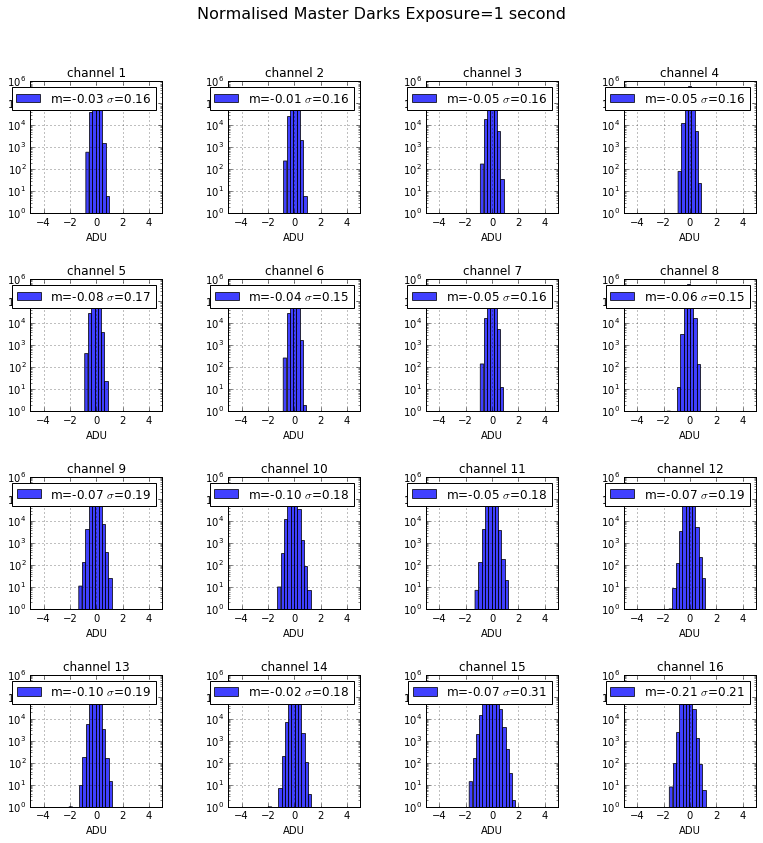

In [55]:
ShowMasterSingleDarkHisto(all_master_darks_exposcaled)

### Save the scaled Master_darks

In [56]:
print masterdark_out_filename


masterdarks_ostrim_sb_exposure240sec.fits


In [57]:
monoc.SaveCCDListIntoFitsFile(all_master_darks_exposcaled,masterdark_out_filename_scaled,mbheader,imagetyp='master_dark')

Filename: (No file associated with this HDUList)
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       4   ()              
1                ImageHDU         7   (511, 2048)   float64   
2                ImageHDU         7   (511, 2048)   float64   
3                ImageHDU         7   (511, 2048)   float64   
4                ImageHDU         7   (511, 2048)   float64   
5                ImageHDU         7   (511, 2048)   float64   
6                ImageHDU         7   (511, 2048)   float64   
7                ImageHDU         7   (511, 2048)   float64   
8                ImageHDU         7   (511, 2048)   float64   
9                ImageHDU         7   (511, 2048)   float64   
10               ImageHDU         7   (511, 2048)   float64   
11               ImageHDU         7   (511, 2048)   float64   
12               ImageHDU         7   (511, 2048)   float64   
13               ImageHDU         7   (511, 2048)   float64   
14               Im

## 9) Produce Multi Darks
================================

### 9.1) Define the required exposures

In [58]:
required_darkexposures=np.array([1.,2.,3.,4.,5.,6.,7.,8.,9.,10.,20.,30.,40.,50.,60.,70.,80.,90.,100.,120.,150.,200.,240.])

In [59]:
def MakeMasterDarkForExposureFromAll(master_darks_subbias,list_exposures,req_expo):
    '''
    Make a Master Dark for a required exposure time
    input : 
          all_master_darks_subbias : collection of darks having their bias subtracted
          list_exposures : list of exposure of the darks in all_master_darks_subbias
          req_expo : required exposure time
    output:
          the masterdark at the required exposure
    
    '''
    
    all_master_darks_exposcaled=[]  # output : a list of master-darks scaled for exposure req_expo

    for chan in range(NB_OF_CHAN_AMPL): # loop over the number of CCD channels
        combined_master_darks_sb = [] 
        for idexp,expo in enumerate(list_exposures):  # loop over the exposures of the darks          
            timenormaliseddark=master_darks_subbias[chan][expo].multiply(req_expo/expo)   # rescale like this ?     
            combined_master_darks_sb.append(timenormaliseddark) 
                        
        all_master_darks_exposcaled.append(ccdproc.Combiner(combined_master_darks_sb).average_combine())
    return all_master_darks_exposcaled


### BAD Combination from statistical point of view ?

### Save all the master darks in fits file

In [60]:
normeddarksmaster_list=[]

for expo in required_darkexposures:   
    masterdark_out_filename_scaled='masterdarks_rescaled_ostrim_exposure{:d}sec.fits'.format(int(expo))
    print masterdark_out_filename_scaled
    normmasterdarks=MakeMasterDarkForExposureFromAll(all_master_darks_subbias,list_exposures,expo)
    monoc.SaveCCDListIntoFitsFile(normmasterdarks,masterdark_out_filename_scaled,mbheader,imagetyp='master_dark')
    normeddarksmaster_list.append(normmasterdarks)

masterdarks_rescaled_ostrim_exposure1sec.fits
Filename: (No file associated with this HDUList)
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       4   ()              
1                ImageHDU         7   (511, 2048)   float64   
2                ImageHDU         7   (511, 2048)   float64   
3                ImageHDU         7   (511, 2048)   float64   
4                ImageHDU         7   (511, 2048)   float64   
5                ImageHDU         7   (511, 2048)   float64   
6                ImageHDU         7   (511, 2048)   float64   
7                ImageHDU         7   (511, 2048)   float64   
8                ImageHDU         7   (511, 2048)   float64   
9                ImageHDU         7   (511, 2048)   float64   
10               ImageHDU         7   (511, 2048)   float64   
11               ImageHDU         7   (511, 2048)   float64   
12               ImageHDU         7   (511, 2048)   float64   
13               ImageHDU         7 

In [ ]:
NB_REQ_EXPOSURES=len(required_darkexposures)

In [ ]:
for id,expo in enumerate(required_darkexposures):
    print 'Exposure = {} seconds :: '.format(expo)
    ShowMasterSingleDarkHisto(normeddarksmaster_list[id])

Exposure = 1.0 seconds :: 
channel 1 Normalised darks mean = -0.0331367731649  darks rms 0.15798476155
channel 2 Normalised darks mean = -0.00972931393833  darks rms 0.157283038347
channel 3 Normalised darks mean = -0.0468270817415  darks rms 0.163987092768
channel 4 Normalised darks mean = -0.0490652178299  darks rms 0.157408813093
channel 5 Normalised darks mean = -0.0797503068159  darks rms 0.165296774301
channel 6 Normalised darks mean = -0.0391836470847  darks rms 0.154109929065
channel 7 Normalised darks mean = -0.0480898216869  darks rms 0.161816410557
channel 8 Normalised darks mean = -0.0621764907641  darks rms 0.151071961964
channel 9 Normalised darks mean = -0.0679246223421  darks rms 0.193471376411
channel 10 Normalised darks mean = -0.104523267429  darks rms 0.183750223197
channel 11 Normalised darks mean = -0.0547215050318  darks rms 0.183564699927
channel 12 Normalised darks mean = -0.0715578116448  darks rms 0.185566567421
channel 13 Normalised darks mean = -0.096595878

/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


channel 1 Normalised darks mean = -4.97051597473  darks rms 23.6977142325
channel 2 Normalised darks mean = -1.45939709075  darks rms 23.592455752
channel 3 Normalised darks mean = -7.02406226122  darks rms 24.5980639153
channel 4 Normalised darks mean = -7.35978267449  darks rms 23.611321964
channel 5 Normalised darks mean = -11.9625460224  darks rms 24.7945161452
channel 6 Normalised darks mean = -5.87754706271  darks rms 23.1164893598
channel 7 Normalised darks mean = -7.21347325303  darks rms 24.2724615836
channel 8 Normalised darks mean = -9.32647361461  darks rms 22.6607942945
channel 9 Normalised darks mean = -10.1886933513  darks rms 29.0207064616
channel 10 Normalised darks mean = -15.6784901143  darks rms 27.5625334796
channel 11 Normalised darks mean = -8.20822575476  darks rms 27.5347049891
channel 12 Normalised darks mean = -10.7336717467  darks rms 27.8349851131
channel 13 Normalised darks mean = -14.4893817159  darks rms 27.8755538485
channel 14 Normalised darks mean = -

In [ ]:
average_dark=np.array(NB_REQ_EXPOSURES,NB_OF_CHAN_AMPL)

for id,expo in enumerate(required_darkexposures):
    for chan in range(NB_OF_CHAN_AMPL):    
        average_dark[id,chan]=all_master_darks_exposcaled[chan][id].data.flatten().mean()
